## Data Exploration
Sarah Go

## Import Libraries and Dataset

In [1]:
import kagglehub
import numpy as np
import pandas as pd

from tabulate import tabulate
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import seaborn as sns
from textblob import TextBlob

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [22]:
# Download latest version
path = kagglehub.dataset_download("bhavikjikadara/fake-news-detection")

print("Path to dataset files:", path)

# load datasets
fake=pd.read_csv(path+'/fake.csv')
true=pd.read_csv(path+'/true.csv')

true['label'] = 'True'
fake['label'] = 'Fake'
all_news = pd.concat([true, fake], ignore_index=True)

Path to dataset files: C:\Users\radadmin\.cache\kagglehub\datasets\bhavikjikadara\fake-news-detection\versions\1


## Preliminary Inspection and Word Clouds

- All/most of the true data was likely sourced from Reuters

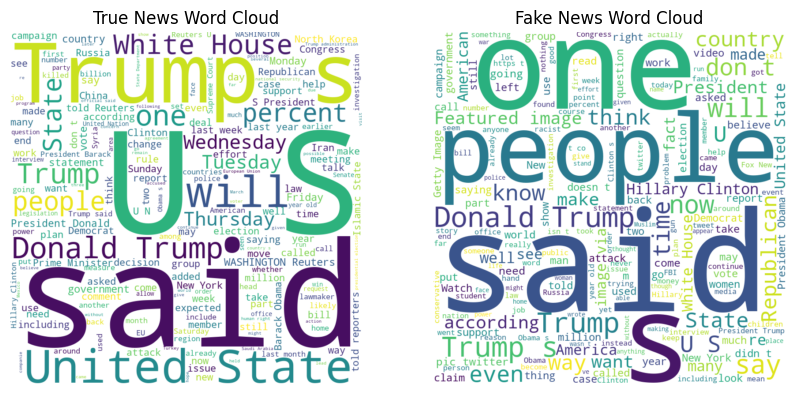

In [54]:
true_text = ' '.join(true['text'].astype(str))
fake_text = ' '.join(fake['text'].astype(str))

true_wordcloud = WordCloud(width=800, height=800, background_color='white').generate(true_text)
fake_wordcloud = WordCloud(width=800, height=800, background_color='white').generate(fake_text)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(true_wordcloud, interpolation='bilinear')
plt.axis('off')
plt
plt.title('True News Word Cloud')

plt.subplot(1, 2, 2)
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Fake News Word Cloud')

plt.show()

In [19]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [20]:
true.tail()

,title,text,subject,date
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"
21416,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017"


In [21]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [22]:
fake.tail()

,title,text,subject,date
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"
23480,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016"


## Fixing Weird Dates

- There are multiple formats used for the dates
- 60 articles have no date. A hyperlink was inserted instead.
- all_news_temp contains converted dates in 'date' column in a standard format (YYYY-MM-DD)

In [ ]:
# Create a temporary copy
all_news_temp = pd.concat([true, fake], ignore_index=True)

# Keep a backup of the original 'date' column
all_news_temp['original_date'] = all_news_temp['date']

# Strip whitespace and first conversion attempt (e.g., 'August 18, 2017')
all_news_temp['date'] = all_news_temp['date'].str.strip()
all_news_temp['date'] = pd.to_datetime(all_news_temp['date'], format='%B %d, %Y', errors='coerce')

# Identify rows that failed the first conversion
invalid_rows = all_news_temp[all_news_temp['date'].isna()]
print("Rows with invalid dates after first conversion:")
print(invalid_rows[['original_date']].head())

# Attempt conversion with a different format (e.g., '19-Feb-18')
all_news_temp.loc[all_news_temp['date'].isna(), 'date'] = pd.to_datetime(
    all_news_temp.loc[all_news_temp['date'].isna(), 'original_date'],  # Use original dates
    format='%d-%b-%y',  
    errors='coerce'
)

# Check remaining invalid rows
still_invalid_rows = all_news_temp[all_news_temp['date'].isna()]
print("Rows with invalid dates after second conversion:")
print(still_invalid_rows[['original_date']].head())

# Attempt conversion with a different format (e.g., 'Dec 17, 2018')
all_news_temp.loc[all_news_temp['date'].isna(), 'date'] = pd.to_datetime(
    all_news_temp.loc[all_news_temp['date'].isna(), 'original_date'],  # Use original dates
    format='%b %d, %Y',  
    errors='coerce'
)

# Check remaining invalid rows
still_invalid_rows = all_news_temp[all_news_temp['date'].isna()]
print("Number of invalid rows after third conversion: ",still_invalid_rows.size)
print("Rows with invalid dates after third conversion:")
print(still_invalid_rows['original_date'])

# Convert to standard format
all_news_temp['date'] = all_news_temp['date'].dt.strftime('%Y-%m-%d')  # Convert to 'YYYY-MM-DD' format
print(all_news_temp[['original_date', 'date']].head())

Rows with invalid dates after first conversion:
      original_date
30467     19-Feb-18
30468     19-Feb-18
30469     19-Feb-18
30470     18-Feb-18
30471     18-Feb-18
Rows with invalid dates after second conversion:
      original_date
30502  Dec 31, 2017
30503  Dec 31, 2017
30504  Dec 31, 2017
30505  Dec 31, 2017
30506  Dec 30, 2017
Number of invalid rows after third conversion:  60
Rows with invalid dates after third conversion:
30775    https://100percentfedup.com/served-roy-moore-v...
36924    https://100percentfedup.com/video-hillary-aske...
36925    https://100percentfedup.com/12-yr-old-black-co...
37256    https://fedup.wpengine.com/wp-content/uploads/...
37257    https://fedup.wpengine.com/wp-content/uploads/...
38849    https://fedup.wpengine.com/wp-content/uploads/...
38850    https://fedup.wpengine.com/wp-content/uploads/...
40350    MSNBC HOST Rudely Assumes Steel Worker Would N...
43286    https://fedup.wpengine.com/wp-content/uploads/...
43287    https://fedup.wpengine.c

## Dataset Balance, Features, Missing Values, Duplicates

Summary of findings: 
- The dataset is well balanced, with 21417 true news articles, and 23481 fake news articles
- There are four features: title, text, subject and date
- There is no missing (NaN) data (BUT some of the dates are invalid, see analysis above)
- There are no articles without titles
- There are some articles without text
- There is some duplicate data: 206 duplicated true news articles, and 3 duplicated fake news articles

The articles without titles and the duplicate articles were dropped from the datasets.

True news dataset shape: (21211, 4)
Fake news dataset shape: (23478, 4)


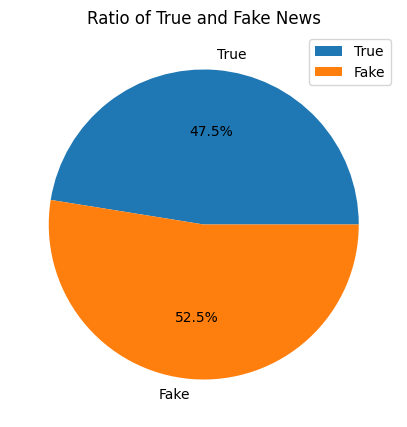

Features in 'True' Dataset:
 ['title', 'text', 'subject', 'date'] 

Features in 'Fake' Dataset:
 ['title', 'text', 'subject', 'date'] 



In [26]:
# Print shape
print("True news dataset shape:",true.shape)
print("Fake news dataset shape:",fake.shape)

# Graph pie chart displaying ratio of true and fake news
plt.figure(figsize=(5,5))
plt.title('Ratio of True and Fake News')
plt.axis('equal')
plt.pie([true.shape[0],fake.shape[0]],labels=['True','Fake'],autopct='%1.1f%%')
plt.legend()
plt.show()

# Print feature names (column names) for both datasets
print("Features in 'True' Dataset:\n", true.columns.tolist(), "\n")
print("Features in 'Fake' Dataset:\n", fake.columns.tolist(), "\n")

In [51]:
# Summary of blank and missing entries in true data
summary_true = {
    "Blank Text Entries": (true['text'].str.strip() == '').sum(),
    "Blank Title Entries": (true['title'].str.strip() == '').sum(),
    "Missing Entries (NaN)": true.isna().sum().sum(),
}

# Convert dictionary to a DataFrame for better tabulation
summary_df = pd.DataFrame(list(summary_true.items()), columns=["Entry Type", "Count"])

# Display the summary in tabular format
print(tabulate(summary_df, headers="keys", tablefmt="grid"))

+----+-----------------------+---------+
|    | Entry Type            |   Count |
+====+=======================+=========+
|  0 | Blank Text Entries    |       1 |
+----+-----------------------+---------+
|  1 | Blank Title Entries   |       0 |
+----+-----------------------+---------+
|  2 | Missing Entries (NaN) |       0 |
+----+-----------------------+---------+


In [50]:
summary_fake = {
    "Blank Text Entries": (fake['text'].str.strip() == '').sum(),
    "Blank Title Entries": (fake['title'].str.strip() == '').sum(),
    "Missing Entries (NaN)": fake.isna().sum().sum(),
}

# Convert dictionary to a DataFrame for better tabulation
summary_df = pd.DataFrame(list(summary_fake.items()), columns=["Entry Type", "Count"])

# Display the summary in tabular format
print(tabulate(summary_df, headers="keys", tablefmt="grid"))

+----+-----------------------+---------+
|    | Entry Type            |   Count |
+====+=======================+=========+
|  0 | Blank Text Entries    |     630 |
+----+-----------------------+---------+
|  1 | Blank Title Entries   |       0 |
+----+-----------------------+---------+
|  2 | Missing Entries (NaN) |       0 |
+----+-----------------------+---------+


In [3]:
# Identify duplicates for both datasets
true_duplicates = true.duplicated().sum()
fake_duplicates = fake.duplicated().sum()

print("Number of Duplicates in 'True' Dataset:", true_duplicates)
print("Number of Duplicates in 'Fake' Dataset:", fake_duplicates)

Number of Duplicates in 'True' Dataset: 206
Number of Duplicates in 'Fake' Dataset: 3


In [4]:
# Drop duplicates
true = true.drop_duplicates()
fake = fake.drop_duplicates()

# Drop articles without text
indices = true[(true['text'].str.strip() == '')].index
true_cleaned = true.drop(indices)

indices = fake[(fake['text'].str.strip() == '')].index
fake_cleaned = fake.drop(indices)

# Print shape
print("True news dataset shape:",true.shape)
print("Fake news dataset shape:",fake.shape)

True news dataset shape: (21211, 4)
Fake news dataset shape: (23478, 4)


## Word Frequency Analysis

After dropping duplicate articles, the top ten most frequent words in text (titles not included), after removing the most common stopwords, were identified for both true and fake news. Also, the top ten most divergent word frequencies between true and fake news were identified. 


Top 10 Fake Words:
['trump', 'said', 'president', 'people', 'just', 'clinton', 'obama', 'like', 'donald', 'news']

Top 10 True Words:
['said', 'trump', 'reuters', 'president', 'state', 'government', 'new', 'house', 'states', 'republican']

Top 10 Divergent Words:
['said', 'reuters', 'government', 'minister', 'china', 'united', 'state', 'washington', 'north', 'republican']


In [45]:
true_text = ' '.join(true['text'].astype(str))
fake_text = ' '.join(fake['text'].astype(str))
all_text = [true_text, fake_text]

# Initialize CountVectorizer with stopword removal
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the data
true_counts = vectorizer.fit_transform([true_text])
fake_counts = vectorizer.fit_transform([fake_text])

# Fit on all text and transform each text separately
vectorizer.fit(all_text)
true_counts = vectorizer.transform([true_text])
fake_counts = vectorizer.transform([fake_text])

# Convert to DataFrames
true_word_freq = pd.DataFrame(true_counts.toarray(), columns=vectorizer.get_feature_names_out()).T
fake_word_freq = pd.DataFrame(fake_counts.toarray(), columns=vectorizer.get_feature_names_out()).T

# Add column names for clarity
true_word_freq.columns = ['Frequency']
fake_word_freq.columns = ['Frequency']

# Get top 10 most frequent words for true and fake news
top_true = true_word_freq.sort_values(by='Frequency', ascending=False).head(10)
top_fake = fake_word_freq.sort_values(by='Frequency', ascending=False).head(10)

In [46]:
# Display top 10 most frequent words for true news
print("Top 10 Most Frequent Words in True News:")
print(tabulate(top_true.reset_index(), headers=['Word', 'Frequency'], tablefmt='grid'))

Top 10 Most Frequent Words in True News:
+----+------------+-------------+
|    | Word       |   Frequency |
+====+============+=============+
|  0 | said       |       97867 |
+----+------------+-------------+
|  1 | trump      |       54098 |
+----+------------+-------------+
|  2 | reuters    |       28681 |
+----+------------+-------------+
|  3 | president  |       27879 |
+----+------------+-------------+
|  4 | state      |       20808 |
+----+------------+-------------+
|  5 | government |       18552 |
+----+------------+-------------+
|  6 | new        |       16758 |
+----+------------+-------------+
|  7 | house      |       16492 |
+----+------------+-------------+
|  8 | states     |       16422 |
+----+------------+-------------+
|  9 | republican |       16149 |
+----+------------+-------------+


In [47]:
# Display top 10 most frequent words for fake news
print("\nTop 10 Most Frequent Words in Fake News:")
print(tabulate(top_fake.reset_index(), headers=['Word', 'Frequency'], tablefmt='grid'))


Top 10 Most Frequent Words in Fake News:
+----+-----------+-------------+
|    | Word      |   Frequency |
+====+===========+=============+
|  0 | trump     |       79300 |
+----+-----------+-------------+
|  1 | said      |       33762 |
+----+-----------+-------------+
|  2 | president |       27714 |
+----+-----------+-------------+
|  3 | people    |       26570 |
+----+-----------+-------------+
|  4 | just      |       20508 |
+----+-----------+-------------+
|  5 | clinton   |       19168 |
+----+-----------+-------------+
|  6 | obama     |       18797 |
+----+-----------+-------------+
|  7 | like      |       18096 |
+----+-----------+-------------+
|  8 | donald    |       17671 |
+----+-----------+-------------+
|  9 | news      |       14620 |
+----+-----------+-------------+


Compare frequencies of words between true and fake news:

In [48]:
# Combine and compare frequencies
comparison = pd.concat([true_word_freq, fake_word_freq], axis=1, keys=['True', 'Fake']).fillna(0)
comparison.columns = ['True_Frequency', 'Fake_Frequency']
comparison['Difference'] = comparison['True_Frequency'] - comparison['Fake_Frequency']

# Get top 10 most divergent words
top_divergent = comparison.sort_values(by='Difference', ascending=False).head(10)

# Display results with tabulate
print("Top 10 Most Divergent Words:")
print(tabulate(top_divergent.reset_index(), headers=['Word', 'True_Frequency', 'Fake_Frequency', 'Difference'], tablefmt='grid'))

Top 10 Most Divergent Words:
+----+------------+------------------+------------------+--------------+
|    | Word       |   True_Frequency |   Fake_Frequency |   Difference |
+====+============+==================+==================+==============+
|  0 | said       |            97867 |            33762 |        64105 |
+----+------------+------------------+------------------+--------------+
|  1 | reuters    |            28681 |              449 |        28232 |
+----+------------+------------------+------------------+--------------+
|  2 | government |            18552 |             9201 |         9351 |
+----+------------+------------------+------------------+--------------+
|  3 | minister   |             8549 |              984 |         7565 |
+----+------------+------------------+------------------+--------------+
|  4 | china      |             8719 |             1254 |         7465 |
+----+------------+------------------+------------------+--------------+
|  5 | united     |   

In [49]:
# Print list of top ten fake words
print("\nTop 10 Fake Words:")
print(top_fake.index.tolist())

# Print list of top ten true words
print("\nTop 10 True Words:")
print(top_true.index.tolist())

# Print list of top ten words
print("\nTop 10 Divergent Words:")
print(top_divergent.index.tolist())


Top 10 Fake Words:
['trump', 'said', 'president', 'people', 'just', 'clinton', 'obama', 'like', 'donald', 'news']

Top 10 True Words:
['said', 'trump', 'reuters', 'president', 'state', 'government', 'new', 'house', 'states', 'republican']

Top 10 Divergent Words:
['said', 'reuters', 'government', 'minister', 'china', 'united', 'state', 'washington', 'north', 'republican']


## Sentiment Analysis

- Sentiment polarity = whether text expresses positive, negative or neutral sentiment. **There does not appear to be a significant difference in sentiment polarity.**
- Sentiment subjectivity = degree of personal opinion present in a statement. Higher subjectivity --> more personal opinion, less factual information. **There appears to be a significant difference in sentiment subjectivity. Fake news is more subjective than true news.** 

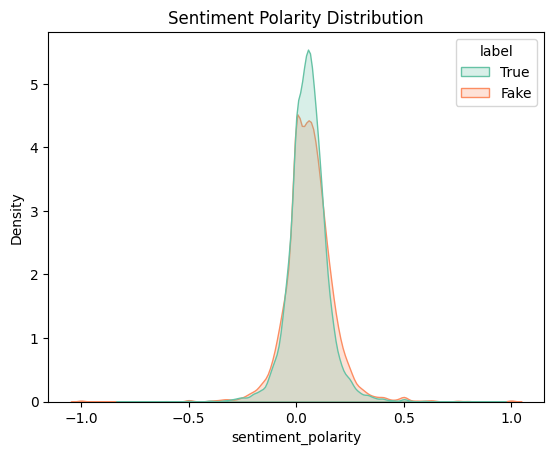

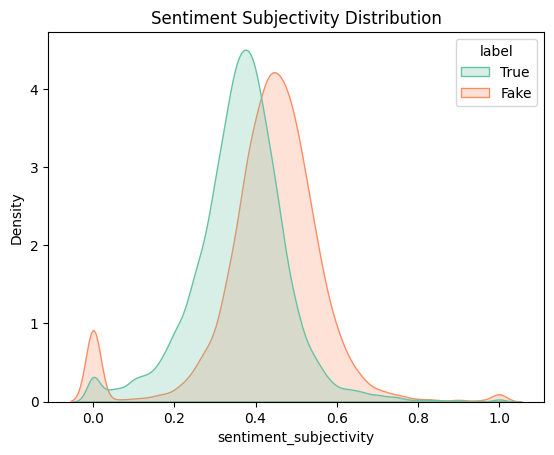

In [ ]:
# Add sentiment scores
all_news['sentiment_polarity'] = all_news['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
all_news['sentiment_subjectivity'] = all_news['text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

# Compare polarity and subjectivity
sns.kdeplot(data=all_news, x='sentiment_polarity', hue='label', fill=True, common_norm=False, palette='Set2')
plt.title("Sentiment Polarity Distribution")
plt.show()

sns.kdeplot(data=all_news, x='sentiment_subjectivity', hue='label', fill=True, common_norm=False, palette='Set2')
plt.title("Sentiment Subjectivity Distribution")
plt.show()

## Temporal Analysis

- True news is skewed towards more recent dates (2017-2018)
- Fake news is approximately uniformly distributed across time

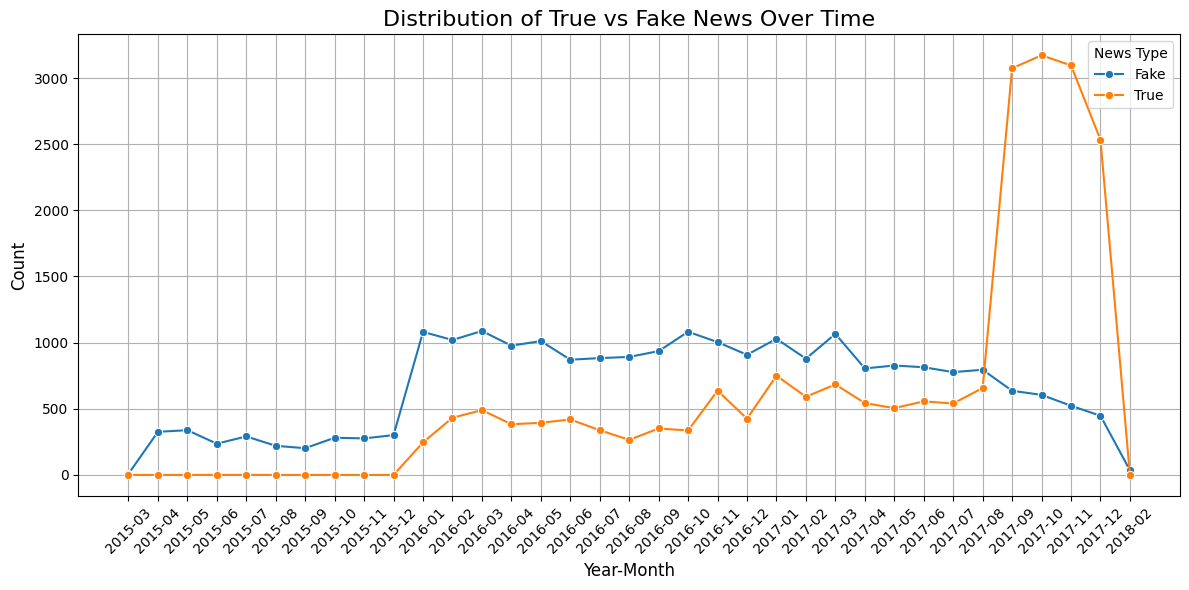

In [ ]:
# Drop rows with NaT values in the 'date' column
all_news_temp = all_news_temp.dropna(subset=['date'])

# Add year-month column
all_news_temp['year_month'] = pd.to_datetime(all_news_temp['date']).dt.to_period('M')

# Group by year_month and label
monthly_counts = all_news_temp.groupby(['year_month', 'label']).size().unstack(fill_value=0)
monthly_counts = monthly_counts.reset_index()
monthly_counts = monthly_counts.melt(id_vars=['year_month'], var_name='label', value_name='count')
monthly_counts['year_month'] = monthly_counts['year_month'].astype(str)

# Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_counts, x='year_month', y='count', hue='label', marker='o')

plt.title('Distribution of True vs Fake News Over Time', fontsize=16)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='News Type', fontsize=10)
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()
